In [163]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
np.bool = np.bool_

import mxnet as mx
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import OffsetSplitter
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)
mx.random.seed(0)

레벨별 분포 가져오기

In [11]:
levels = [
    [],                        # Level 1: Total
    ['state_id'],              # Level 2: State
    ['store_id'],              # Level 3: Store
    ['cat_id'],                # Level 4: Category
    ['dept_id'],               # Level 5: Department
    ['state_id', 'cat_id'],    # Level 6: State-Category
    ['state_id', 'dept_id'],   # Level 7: State-Department
    ['store_id', 'cat_id'],    # Level 8: Store-Category
    ['store_id', 'dept_id'],   # Level 9: Store-Department
    ['item_id'],               # Level 10: Item
    ['item_id', 'state_id'],   # Level 11: Item-State
    ['item_id', 'store_id']    # Level 12: Individual
]

In [ ]:
level = 9

start_date = pd.to_datetime('2011-01-29')
agg_df = pd.read_csv(f'../data/preprocessed/agg_df_level_{level}.csv')
calendar_df = pd.read_csv('../data/preprocessed/calendar_df.csv')

agg_df['d'] = agg_df['d'].apply(lambda x: int(x.split('_')[1]) - 1)
agg_df['d'] = start_date + pd.to_timedelta(agg_df['d'], unit='D')
agg_df.insert(0, 'id', agg_df[levels[level-1]].apply(lambda x: '_'.join(x), axis=1))
agg_df.drop(columns=['level']+levels[level-1], inplace=True)

calendar_df['d'] = calendar_df['d'].apply(lambda x: int(x.split('_')[1]) - 1)
calendar_df['d'] = start_date + pd.to_timedelta(calendar_df['d'], unit='D')

merge_df = agg_df.merge(calendar_df, on="d", how="left")

In [ ]:
prediction_length = 28
step_size = 7 

train_df = merge_df[merge_df["d"] < merge_df["d"].max() - pd.Timedelta(days=prediction_length - 1)]
test_df = merge_df.copy()

print(f"Train 기간: 1 ~ {(train_df['d'].max() - train_df['d'].min()).days + 1}")
print(f"Test 기간: 1 ~ {(test_df['d'].max() - test_df['d'].min()).days + 1}")

train_df.set_index('d', inplace=True)
test_df.set_index('d', inplace=True)

train_dataset = PandasDataset.from_long_dataframe(
    train_df,
    item_id="id",  
    target="sales_sum",  
    feat_dynamic_real=[
        "sales_mean", "sales_std", "sales_max", "sales_min", 
        "sales_lag1", "sales_lag7", "sales_lag28",  
        "sales_rolling7_mean", "sales_rolling28_mean", "sales_trend", 
        "release_mean", "out_of_stock_mean", 
        "sell_price_mean", "sell_price_std", "sell_price_max", "sell_price_min", 
        "sell_price_diff", "sell_price_trend", "sell_price_in_store_mean",
        "snap_CA", "snap_TX", "snap_WI",  
        "year_delta", "quarter_sin", "quarter_cos", "month_sin", "month_cos",  
        "day_sin", "day_cos", "weekday_sin", "weekday_cos",
        "event_count", "event_name_1_enc", "event_name_2_enc",  
        "event_type_1_enc", "event_type_2_enc"
    ],
)

test_dataset = PandasDataset.from_long_dataframe(
    test_df,
    item_id="id",  
    target="sales_sum",  
    feat_dynamic_real=[
        "sales_mean", "sales_std", "sales_max", "sales_min", 
        "sales_lag1", "sales_lag7", "sales_lag28",  
        "sales_rolling7_mean", "sales_rolling28_mean", "sales_trend", 
        "release_mean", "out_of_stock_mean", 
        "sell_price_mean", "sell_price_std", "sell_price_max", "sell_price_min", 
        "sell_price_diff", "sell_price_trend", "sell_price_in_store_mean",
        "snap_CA", "snap_TX", "snap_WI",  
        "year_delta", "quarter_sin", "quarter_cos", "month_sin", "month_cos",  
        "day_sin", "day_cos", "weekday_sin", "weekday_cos",
        "event_count", "event_name_1_enc", "event_name_2_enc",  
        "event_type_1_enc", "event_type_2_enc"
    ],
)

Train 기간: 1 ~ 1913
Test 기간: 1 ~ 1941


In [151]:
train_dataset

PandasDataset<size=70, freq=D, num_feat_dynamic_real=36, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [158]:
for i in train_dataset:
    print(i['feat_dynamic_real'].shape)
    break

(36, 1913)


In [ ]:
epochs = 1
batch_size = 64
learning_rate = 1e-3

estimator = DeepAREstimator(
    freq="D",
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
    )
)

predictor = estimator.train(train_dataset)

In [124]:
quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]

forecast_it, test_it = make_evaluation_predictions(dataset=test_dataset, predictor=predictor)
forecasts = list(forecast_it)
tests = list(test_it)

evaluator = Evaluator(quantiles=quantiles)
agg_metrics, item_metrics = evaluator(tests, forecasts, num_series=len(tests))

Running evaluation: 100%|██████████| 70/70 [00:00<00:00, 222.93it/s]


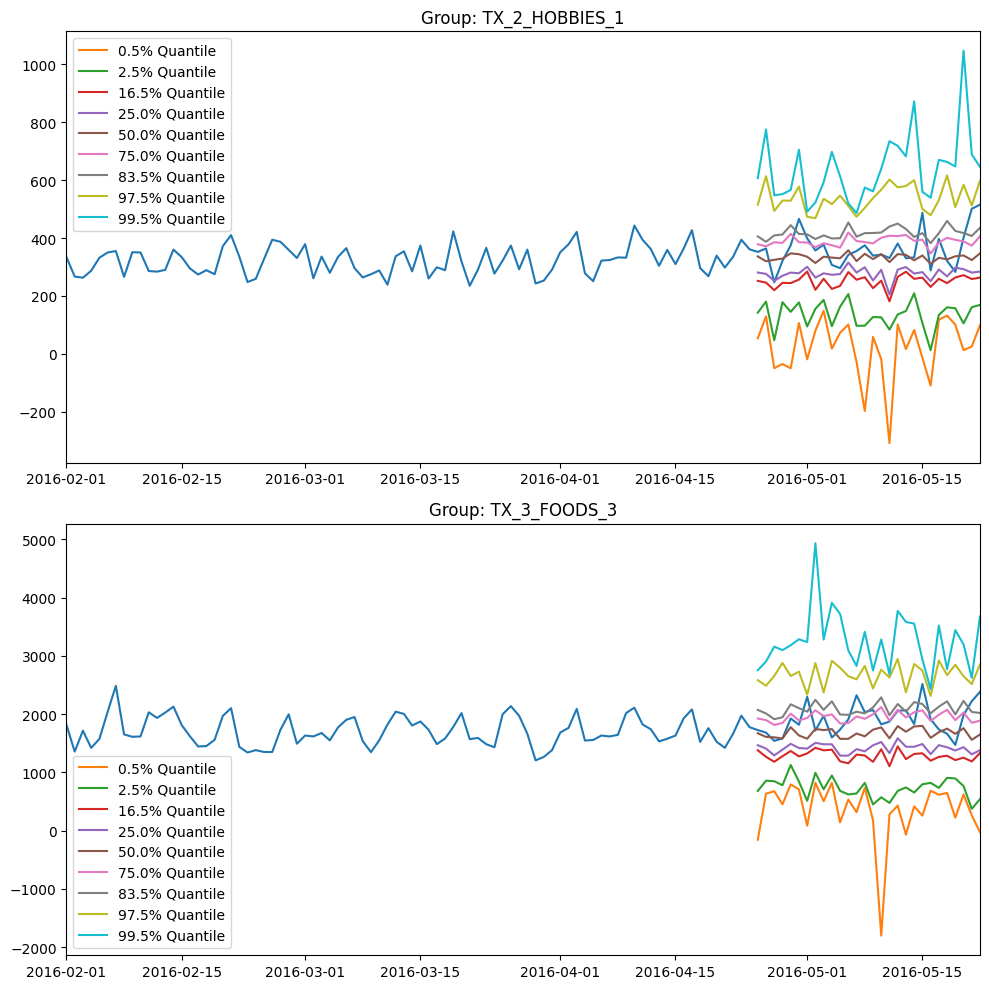

In [ ]:
n_plot = 2

group_df = merge_df.groupby('id')
group_keys = list(group_df.groups.keys())
indices = np.random.choice(np.arange(0, len(group_keys)), size=n_plot, replace=False)

forecast_it, test_it = make_evaluation_predictions(dataset=test_dataset, predictor=predictor)
forecast_data = np.array([forecast.samples for forecast in forecast_it]).transpose(0, 2, 1) # (70, 28, 100)

fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
for index, ax in zip(indices, axes):
    group_data = group_df.get_group(group_keys[index])
    ax.plot(group_data['d'], group_data['sales_sum'])
    for q in quantiles:
        quantile_data = np.percentile(forecast_data[index], q * 100, axis=-1)
        ax.plot(group_data['d'][-prediction_length:], quantile_data, label=f'{q*100}% Quantile')
    ax.set_xlim(group_data['d'].iloc[-4*prediction_length], group_data['d'].iloc[-1])
    ax.set_title(f"{group_keys[index]}")
    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

레벨별 모델 가져오기

레벨별 시점별 분위수 샘플링 기반? 예측

각 시점 모델 증류 (Decision Tree)